In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf #magical gradient computation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
from nltk.corpus import stopwords

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


# Any results you write to the current directory are saved as output.

In [12]:
data = pd.read_csv('data.csv')
data = data.sample(frac = 1)
data.head()

,URLs,Headline,Body,Label
3467,http://beforeitsnews.com/sports/2017/10/106-hb...,"10/6: HBD Eddie, Tom, Gene, Jeff, Joel & Radha...",Warning Something Big Is About to Happen in Am...,0
414,https://www.nytimes.com/2017/10/07/sports/base...,Cubs Open Title Defense With a One-Two Punch F...,"The Nationals, on the other hand, claimed the ...",1
2775,http://beforeitsnews.com/scandals/2017/09/vati...,Vatican Kidnaps Teenage Girl Leaked Letter Says,Vatican Kidnaps Teenage Girl Leaked Letter Say...,0
2014,http://www.cnn.com/videos/us/2017/10/09/wildfi...,Flames engulf California wine country,Chat with us in Facebook Messenger. Find out w...,1
50,http://beforeitsnews.com/sports/2017/10/107-ch...,"10/7: Chuck Axed; HBD Brickyard, Adam, Moonlig...",Red Flag Warning: These California Wildfires A...,0


In [13]:
data['Length'] = [len(headline) for headline in data['Headline']]
data.head()

,URLs,Headline,Body,Label,Length
3467,http://beforeitsnews.com/sports/2017/10/106-hb...,"10/6: HBD Eddie, Tom, Gene, Jeff, Joel & Radha...",Warning Something Big Is About to Happen in Am...,0,86
414,https://www.nytimes.com/2017/10/07/sports/base...,Cubs Open Title Defense With a One-Two Punch F...,"The Nationals, on the other hand, claimed the ...",1,66
2775,http://beforeitsnews.com/scandals/2017/09/vati...,Vatican Kidnaps Teenage Girl Leaked Letter Says,Vatican Kidnaps Teenage Girl Leaked Letter Say...,0,47
2014,http://www.cnn.com/videos/us/2017/10/09/wildfi...,Flames engulf California wine country,Chat with us in Facebook Messenger. Find out w...,1,37
50,http://beforeitsnews.com/sports/2017/10/107-ch...,"10/7: Chuck Axed; HBD Brickyard, Adam, Moonlig...",Red Flag Warning: These California Wildfires A...,0,83


In [14]:
data['Length'].describe()

count    4009.000000
mean       60.104016
std        22.660900
min         6.000000
25%        48.000000
50%        60.000000
75%        69.000000
max       653.000000
Name: Length, dtype: float64

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ritik/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
real_text = ' '.join(data[data['Label'] == 1]['Headline'])
fake_text = ' '.join(data[data['Label'] == 0]['Headline'])
fake_words = [word for word in nltk.tokenize.word_tokenize(fake_text) if word not in stopwords.words('english') and len(word) > 3]
real_words = [word for word in nltk.tokenize.word_tokenize(real_text) if word not in stopwords.words('english') and len(word) > 3]

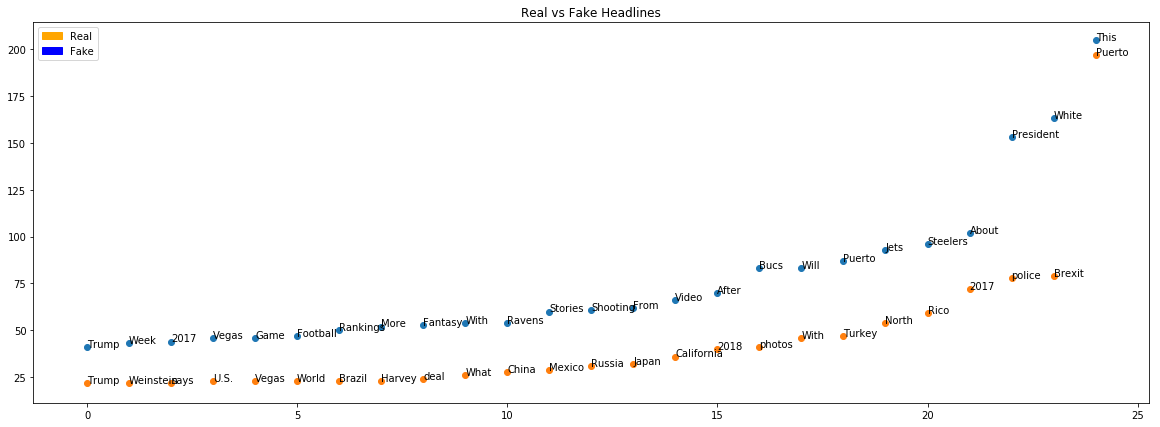

In [20]:
common_fake = nltk.FreqDist(fake_words).most_common(25)
common_real =nltk.FreqDist(real_words).most_common(25)
fake_ranks = []
fake_counts = []
real_ranks = []
real_counts = []

for ii, word in enumerate(reversed(common_fake)):
    fake_ranks.append(ii)
    fake_counts.append(word[1])

for ii, word in enumerate(reversed(common_real)):
    real_ranks.append(ii)
    real_counts.append(word[1])

plt.figure(figsize=(20, 7))

plt.scatter(fake_ranks, fake_counts)

for labels, fake_rank, fake_count in zip(common_fake, fake_ranks, fake_counts):
    plt.annotate(
        labels[0],
        xy = (fake_rank, fake_count)
    )

plt.scatter(real_ranks, real_counts)
plt.title('Real vs Fake Headlines')

for labels, real_rank, real_count in zip(common_real, real_ranks, real_counts):
    plt.annotate(
        labels[0],
        xy = (real_rank, real_count)
    )
    
real_patch = mpatches.Patch(color='orange', label='Real')
fake_patch = mpatches.Patch(color='blue', label='Fake')
plt.legend(handles=[real_patch, fake_patch])

plt.show()

    

In [21]:
def pad(x):
    
    if len(x) < 69:
        
        return x + ' ' * (69 - len(x))
    
    return x

def trim(x):
    
    if len(x) > 69:
        
        return x[:69]
    
    return x

data['Headline'] = data['Headline'].apply(pad)
data['Headline'] = data['Headline'].apply(trim)
data['Length'] = [len(headline) for headline in data['Headline']]
data.describe()

,Label,Length
count,4009.000000,4009.0
mean,0.466949,69.0
std,0.498969,0.0
min,0.000000,69.0
25%,0.000000,69.0
50%,0.000000,69.0
75%,1.000000,69.0
max,1.000000,69.0


In [22]:
text = ' '.join(data['Headline'])
dictionary_size = len(set(text))
dictionary = sorted(set(text))
character_map = { k:v for v, k in enumerate(dictionary) }
max_length = 69
batch_size = 50

In [23]:
def to_input(sentence, character_map, dictionary_size):
    
    sentence = np.array([character_map[char] for char in sentence])
    one_hot = np.zeros((len(sentence), dictionary_size))
    one_hot[np.arange(len(sentence)), sentence] = 1
    return one_hot

def batch(sentences, labels, start, batch_size):
    
    if start + batch_size < len(sentences):
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start: start + batch_size ]]
        labels = [label for label in labels[start: start + batch_size ]]
        start = start + batch_size
    
    else:
        
        inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences[start:]]
        labels = [label for label in labels[start:]]
        start = 0
    
    return np.array(inputs), np.array(labels) , start

def test_batch(sentences, labels):
    
        
    inputs = [to_input(sentence, character_map, dictionary_size) for sentence in sentences]
    labels = [label for label in labels]

    return np.array(inputs), np.array(labels)

In [24]:
inputs = tf.placeholder(tf.float32, [None, max_length, dictionary_size])
labels = tf.placeholder(tf.int64, [None])
hidden_size = 512
cell = tf.contrib.rnn.LSTMCell(hidden_size, state_is_tuple = True)
initial_state = tf.contrib.rnn.LSTMStateTuple(tf.placeholder(tf.float32, [None, hidden_size], name = "c_init"), 
                                             tf.placeholder(tf.float32, [None, hidden_size], name = "h_init"))

with tf.variable_scope("softmax") as softmax:
    
    W_h = tf.get_variable("Wh", 
        shape = [hidden_size, 2], 
        dtype = tf.float32,
        initializer = tf.random_normal_initializer(.1)
    )

    b_h = tf.get_variable("bh", 
        shape = 2,
        dtype = tf.float32,
        initializer = tf.ones_initializer()
    )

outputs, state = tf.nn.dynamic_rnn(cell, inputs, initial_state = initial_state)

logits = tf.matmul(outputs[:,-1, :], W_h) + b_h

loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels = labels, logits = logits
    )
)

accuracy = tf.reduce_mean(
    tf.cast(tf.equal(
        tf.argmax(logits, 1),
        tf.cast(labels, tf.int64)
    ), 
    tf.float32)
)

optimizer = tf.train.AdamOptimizer(.001)

train_step = optimizer.minimize(loss)





In [37]:
save_path = 'checkpoints/'
model_name = 'my_model'
if not os.path.exists(save_path):
    os.makedirs(save_path)
...
saver = tf.train.Saver()
save_path_full = os.path.join(save_path, model_name)


with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)

    initial = sess.run(cell.zero_state(50, tf.float32))

    start = 0
    inputs_, targets_, start = batch(data["Headline"][:3350], data["Label"][:3350], start, batch_size)

    for step in range(1000):
        _, initial = sess.run([train_step, initial_state], feed_dict = {
            inputs:inputs_, 
            labels:targets_,
            initial_state:initial
        })

        inputs_, targets_, start = batch(data["Headline"][:3350], data["Label"][:3350], start, batch_size)


        if step % 100 == 0:

            test_inputs, test_targets = test_batch(data["Headline"][3350:], data["Label"][3350:])
            cost, acc = sess.run([loss, accuracy], feed_dict = {
            inputs:test_inputs, 
            labels:test_targets,
            initial_state:sess.run(cell.zero_state(len(data["Label"][3350:]), tf.float32))
            })

            print(cost, acc)

    saver.save(sess, save_path_full)
            
            

2.780674 0.5174507
0.45088315 0.75872535
0.5540943 0.6949924
0.5175327 0.79817903
0.40012005 0.8300455
0.39245465 0.8179059
0.3782379 0.85887706
0.40897 0.831563
0.38386512 0.84218514
0.41582903 0.8482549
